# How to estimate templates from Dandisets
The purpose of this draft notebook is to showcase how templates can be calculated by means of the `SortingAnalyzer` object.


In [1]:
from dandi.dandiapi import DandiAPIClient
from spikeinterface.extractors import NwbRecordingExtractor, IblSortingExtractor

client = DandiAPIClient.for_dandi_instance("dandi")

# We specifiy a dataset by is dandiset_id and its asset path
dandiset_id = "000409"
dandiset = client.get_dandiset(dandiset_id)

asset_path = "sub-KS042/sub-KS042_ses-8c552ddc-813e-4035-81cc-3971b57efe65_behavior+ecephys+image.nwb"
recording_asset = dandiset.get_asset_by_path(path=asset_path)
url = recording_asset.get_content_url(follow_redirects=True, strip_query=True)
file_path = url


# Note that this ElectricalSeries corresponds to the data from probe 00
electrical_series_path = "acquisition/ElectricalSeriesAp00"
recording = NwbRecordingExtractor(file_path=file_path, stream_mode="remfile", electrical_series_path=electrical_series_path)  
session_id = recording._file["general"]["session_id"][()].decode()
eid = session_id.split("-chunking")[0] # eid : experiment id


# We use the sorting extractor from the IBL spike sorting pipeline that matches with eid
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one_instance = ONE(password='international')


# Then we match the available probes with the probe number in the electrical series path
pids, probes = one_instance.eid2pid(eid)
probe_number = electrical_series_path.split("Ap")[-1]

sorting_pid = None 
for pid, probe in zip(pids, probes):
    probe_number_in_pid = probe[-2:]
    if probe_number_in_pid == probe_number:
        sorting_pid = pid
        break
    
    
sorting = IblSortingExtractor(pid=sorting_pid, one=one_instance, good_clusters_only=True)

Error 403 while sending HEAD request to https://api.dandiarchive.org/api/assets/a0a735eb-fcc6-4ec4-af3b-e590d0706d45/download/: 


/home/heberto/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/average_template_25.nrrd


We now have our sorting and recording objects. We perform some preprocessing on our recording and slice ouf objects so we only estimate templates from the last minutes of the data.

In [2]:
from spikeinterface.preprocessing import astype, phase_shift, common_reference, highpass_filter

pre_processed_recording = common_reference(
    highpass_filter(phase_shift(astype(recording=recording, dtype="float32")), freq_min=1.0)
)


# take first and last minute
sampling_frequency_recording =pre_processed_recording.sampling_frequency
sorting_sampling_frequency = sorting.sampling_frequency
num_samples = pre_processed_recording.get_num_samples()

# Take the last 10 minutes of the recording
minutes = 10
seconds = minutes * 60
samples_before_end = int(seconds * sampling_frequency_recording)

start_frame_recording = num_samples - samples_before_end
end_frame_recording = num_samples

recording_end = pre_processed_recording.frame_slice(
    start_frame=start_frame_recording,
    end_frame=end_frame_recording
)

# num_samples = sorting.get_num_frames()
samples_before_end = int(seconds * sorting_sampling_frequency)
start_frame_sorting = num_samples - samples_before_end
end_frame_sorting = num_samples

sorting_end = sorting.frame_slice(
    start_frame=start_frame_sorting,
    end_frame=end_frame_sorting
)


We now use the `SortingAnalyzer` object to estimate templates.

In [3]:
from spikeinterface.core import create_sorting_analyzer

analyzer = create_sorting_analyzer(sorting_end, recording_end, sparse=False, folder=f"analyzer_{eid}")


random_spike_parameters = {
    "method": "all",
}


template_extension_parameters = {
    "ms_before": 3.0,
    "ms_after": 5.0,
    "operators": ["average", "std"],
}

extensions = {
    "random_spikes": random_spike_parameters,
    "templates": template_extension_parameters,
}

analyzer.compute_several_extensions(
    extensions=extensions,
    n_jobs=-1,
    progress_bar=True,
)

/home/heberto/development/spikeinterface/src/spikeinterface/core/baserecordingsnippets.py:244: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


estimate_templates_with_accumulator:   0%|          | 0/600 [00:00<?, ?it/s]

In [4]:
templates_extension = analyzer.get_extension("templates")
template_object = templates_extension.get_data(outputs="Templates")

That's it. We now have our data in a templates object (note the outputs keyword on `get_data`). As a visual test that the pipeline works we show how the best chanenl (defined as the one with the maximum peak to peak amplitude) and plot some unit's templates for that channel.

In [5]:
import numpy as np



def find_channels_with_max_peak_to_peak_vectorized(templates_array):
    """
    Find the channel indices with the maximum peak-to-peak value in each waveform template
    using a vectorized operation for improved performance.

    Parameters:
    templates_array (numpy.ndarray): The waveform templates_array, typically a 3D array (units x time x channels).

    Returns:
    numpy.ndarray: An array of indices of the channel with the maximum peak-to-peak value for each unit.
    """
    # Compute the peak-to-peak values along the time axis (axis=1) for each channel of each unit
    peak_to_peak_values = np.ptp(templates_array, axis=1)

    # Find the indices of the channel with the maximum peak-to-peak value for each unit
    best_channels = np.argmax(peak_to_peak_values, axis=1)

    return best_channels




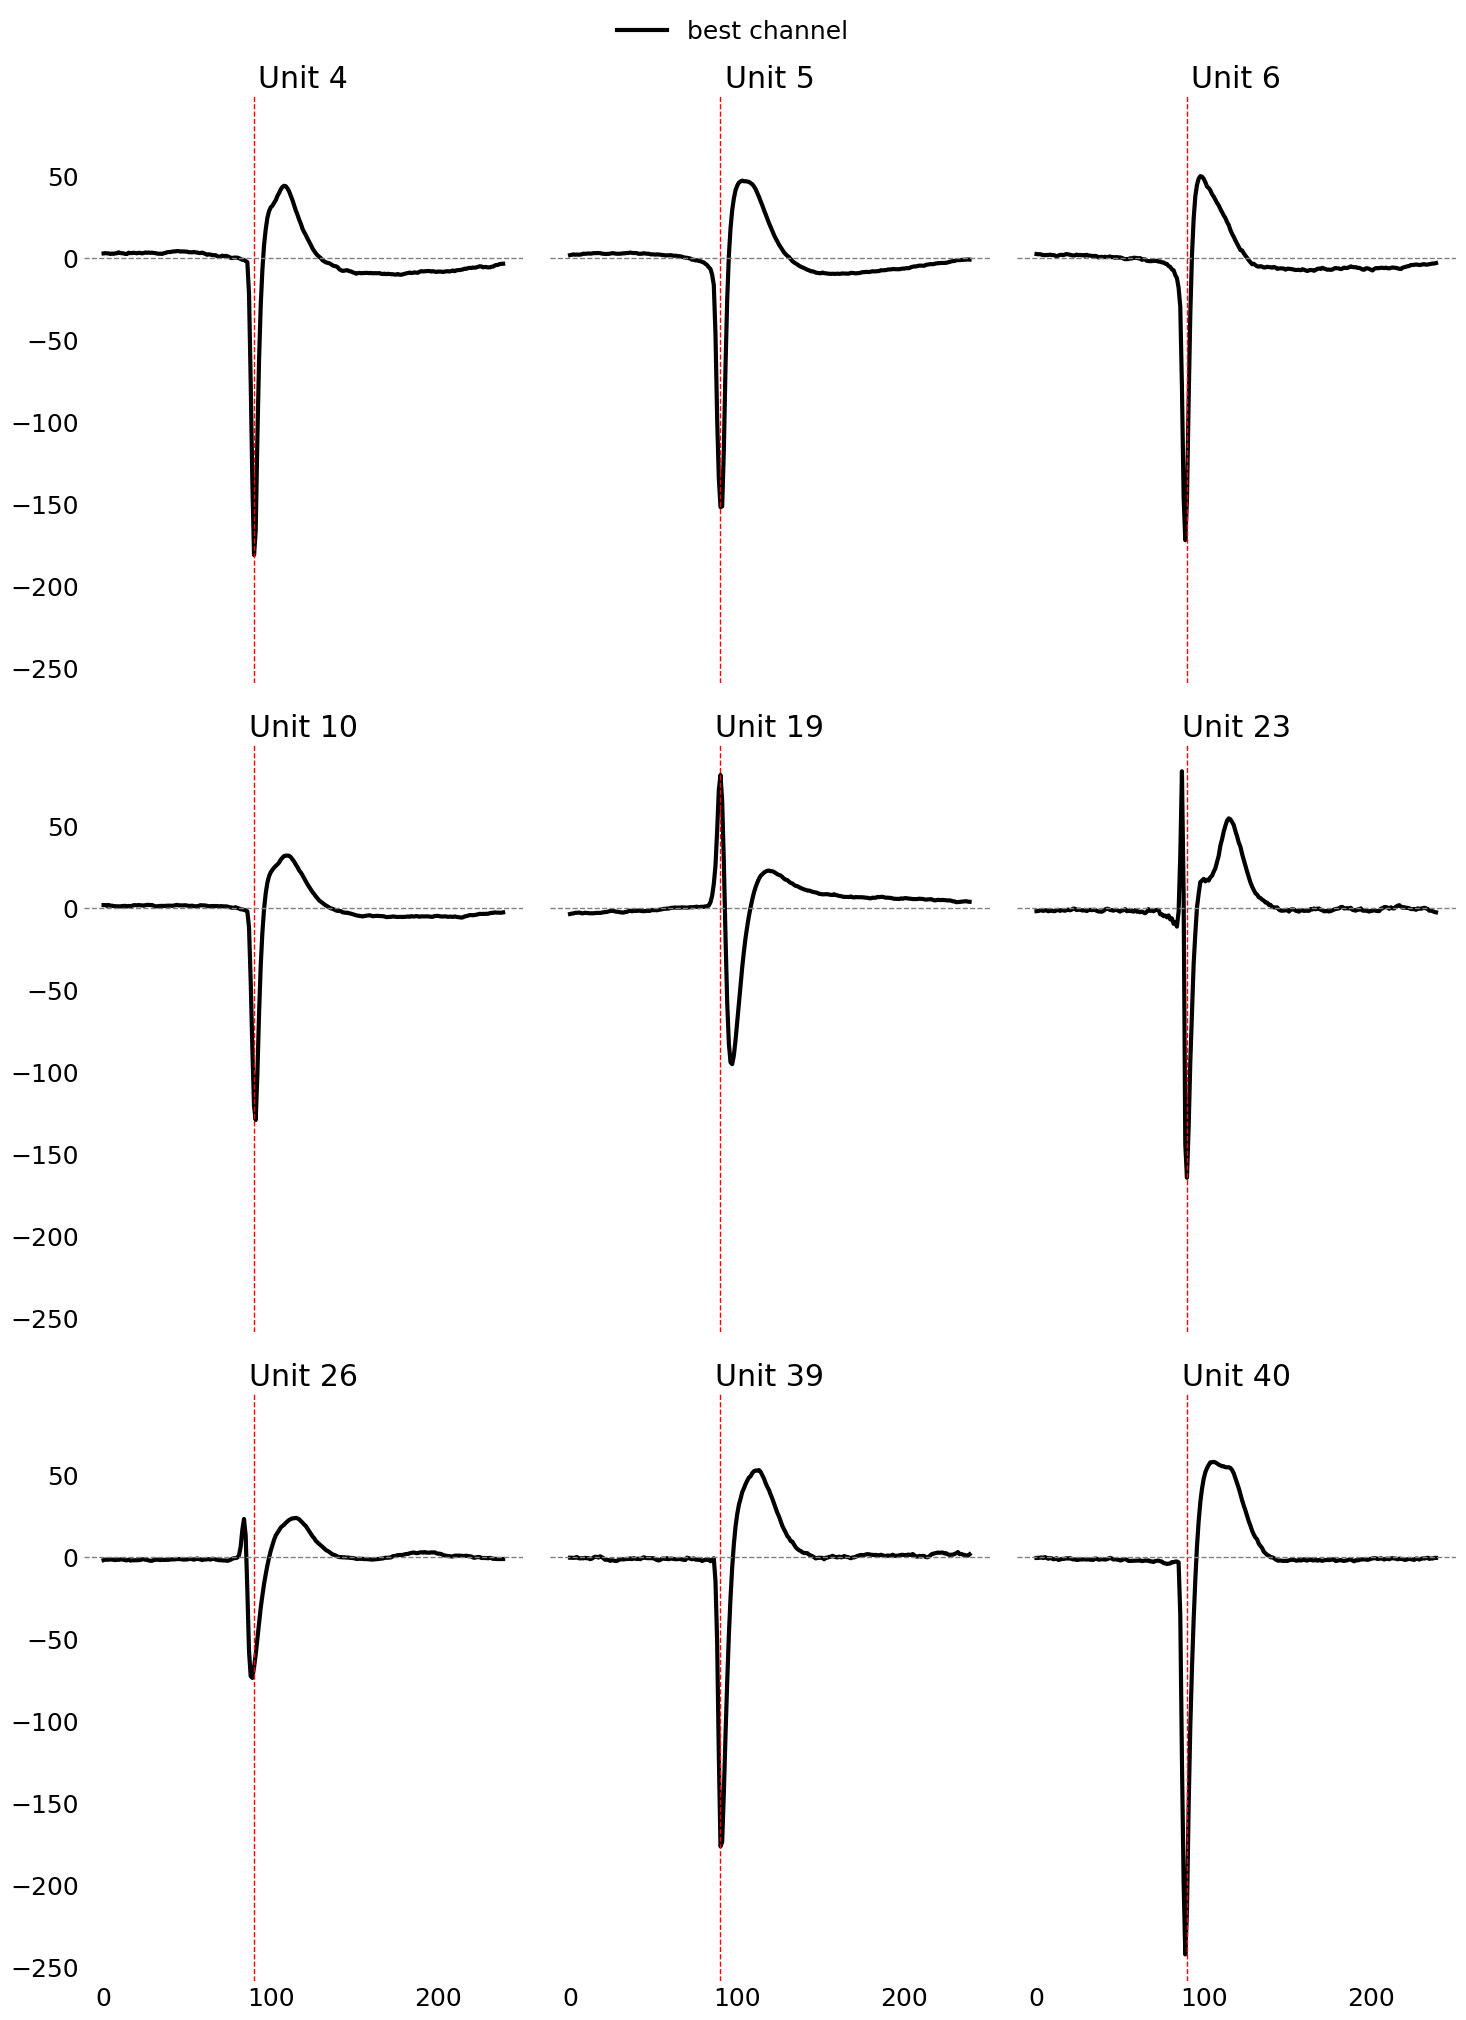

In [6]:
import matplotlib.pyplot as plt

# Adjust global font size
plt.rcParams.update({"font.size": 18})

unit_ids = template_object.unit_ids
best_channels = find_channels_with_max_peak_to_peak_vectorized(template_object.templates_array)


num_columns = 3
num_rows = 3

fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 20), sharex=True, sharey=True)

center = template_object.nbefore

for unit_index, unit_id in enumerate(unit_ids[: num_columns * num_rows]):
    row, col = divmod(unit_index, num_columns)
    ax = axs[row, col]
    best_channel = best_channels[unit_index]

    ax.plot(template_object.templates_array[unit_index, :, best_channel], linewidth=3, label="best channel", color="black")

    ax.axvline(center, linestyle="--", color="red", linewidth=1)
    ax.axhline(0, linestyle="--", color="gray", linewidth=1)
    ax.set_title(f"Unit {unit_id}")

    # Hide all spines and ticks
    ax.tick_params(axis="both", which="both", length=0)

    # Hide all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()

# Create the legend with specified colors
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False)